### Descripción del proyecto
Trabajas para la tienda online Ice que vende videojuegos por todo el mundo. Las reseñas de usuarios y expertos, los géneros, las plataformas (por ejemplo, Xbox o PlayStation) y los datos históricos sobre las ventas de juegos están disponibles en fuentes abiertas. Tienes que identificar patrones que determinen si un juego tiene éxito o no. Esto te permitirá detectar proyectos prometedores y planificar campañas publicitarias.

Delante de ti hay datos que se remontan a 2016. Imaginemos que es diciembre de 2016 y estás planeando una campaña para 2017.

Lo importante es adquirir experiencia de trabajo con datos. Realmente no importa si estás pronosticando las ventas de 2017 en función de los datos de 2016 o las ventas de 2027 en función de los datos de 2026.

El dataset contiene una columna "rating" que almacena la clasificación ESRB de cada juego. El Entertainment Software Rating Board (la Junta de clasificación de software de entretenimiento) evalúa el contenido de un juego y asigna una clasificación de edad como Adolescente o Adulto.

## 1.1  Propósito del Proyecto

- identificar patrones que determinen si un juego tiene éxito o no.
- detectar proyectos prometedores y planificar campañas publicitarias.

## 1.2  Inicialización

In [1]:
# Cargar todas las librerías

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

## 1.3  Cargar datos

In [2]:
df_games = pd.read_csv('/datasets/games.csv')

## 1.4  Revisar los datos

In [3]:
df_games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


## Observaciones 
- Contamos con 10 columnas con información de las ventas de videojuegos de diferentes paises y otras columnas con información util que utilizaremos mas tarde.
- Tenemos tambien algunos valores ausentes especialemte significativos en las columnas "Critic_Score", "User_Score" y "Rating", debemos asegurarnos si es conveninte o no rellenar estos valores ausentes.
- Las columnas tienen nombres en mayusculas, las cuales debemos procesar para hacer nuestro analisis ma eficiente.
- Debemos cambiar algunos tipos de datos como enla columna "Year_of_Release" que su tipo de dato es flotante y nos conviene mas covertirlo en un formato datetime.
- la columna "User_Score" es un tipo de dato object, puede que sea mas conveniente convertirlo en un tipo de dato flotante.


---

#  Preparar los datos

In [5]:
# Paso 1: Reemplazar nombres de columnas con minúsculas
df_games.columns = df_games.columns.str.lower()

# Paso 2: Convertir tipos de datos necesarios
# Convertir year_of_release a formato datetime (usaremos solo el año)
df_games['year_of_release'] = pd.to_datetime(df_games['year_of_release'], format='%Y', errors='coerce')

# Convertir user_score a tipo float, manejando posibles valores no numéricos
df_games['user_score'] = pd.to_numeric(df_games['user_score'], errors='coerce')

# Paso 3: Descripción de los cambios
print("Cambios realizados:")
print("1. Nombres de columnas convertidos a minúsculas.")
print("2. 'year_of_release': Convertido a datetime para facilitar análisis basado en tiempo.")
print("3. 'user_score': Convertido a float para tratar puntuaciones como valores numéricos.")

Cambios realizados:
1. Nombres de columnas convertidos a minúsculas.
2. 'year_of_release': Convertido a datetime para facilitar análisis basado en tiempo.
3. 'user_score': Convertido a float para tratar puntuaciones como valores numéricos.


---

# Trabajemos los valores ausentes

### Posibles columnas afectadas:

- name: Son nombres únicos de juegos. Si están ausentes, no se puede recuperar la información, por lo que se podrían eliminar estas filas.

- year_of_release: Los juegos sin año son difíciles de analizar cronológicamente. Podríamos eliminarlos o rellenarlos si encontramos patrones.

- critic_score y user_score: Son datos importantes, pero no siempre están disponibles. Podríamos rellenarlos con valores como la media por género/plataforma o eliminarlos.

- rating: Clasificación ESRB. Si falta, podría deberse a juegos sin clasificación oficial. Podríamos rellenar con "Sin clasificación" o dejarlos vacíos.

Abreviatura TBD:

En la columna user_score, "TBD" significa "por determinar". Lo trataremos como valores ausentes (NaN) para mantener coherencia.

In [6]:
# Manejo de valores ausentes

# Eliminar filas sin nombre de juego, ya que es información esencial
df_games = df_games.dropna(subset=['name'])

# Rellenar year_of_release con el año más frecuente (moda) como aproximación
year_mode = df_games['year_of_release'].mode()[0]
df_games['year_of_release'] = df_games['year_of_release'].fillna(year_mode)

# Rellenar critic_score y user_score con la media por género como aproximación
df_games['critic_score'] = df_games.groupby('genre')['critic_score'].transform(
    lambda x: x.fillna(x.mean())
)
df_games['user_score'] = df_games.groupby('genre')['user_score'].transform(
    lambda x: x.fillna(x.mean())
)

# Rellenar rating con "Sin clasificación" para juegos sin una clasificación oficial
df_games['rating'] = df_games['rating'].fillna('Sin clasificación')

# Manejar "TBD" en user_score, convirtiéndolos en NaN
df_games['user_score'] = df_games['user_score'].replace('TBD', np.nan)

# Confirmar valores ausentes después del tratamiento
print(df_games.isnull().sum())

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64


### Posibles razones de valores ausentes
- critic_score y user_score:
Podrían faltar para juegos menos populares o recién lanzados, ya que no se evaluaron.
- rating:
Algunos juegos pueden no haber solicitado una clasificación oficial, especialmente en mercados pequeños o para plataformas digitales.


---

# Calcular ventas totales

Vamos a calcular las ventas totales de cada juego sumando las ventas en todas las regiones y guardarlas en una nueva columna llamada total_sales.

In [7]:
# Crear una nueva columna con las ventas totales sumando las regiones
df_games['total_sales'] = df_games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

# Verificar los resultados (muestra las primeras filas con la nueva columna)
print(df_games[['name', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales']].head())

                       name  na_sales  eu_sales  jp_sales  other_sales  \
0                Wii Sports     41.36     28.96      3.77         8.45   
1         Super Mario Bros.     29.08      3.58      6.81         0.77   
2            Mario Kart Wii     15.68     12.76      3.79         3.29   
3         Wii Sports Resort     15.61     10.93      3.28         2.95   
4  Pokemon Red/Pokemon Blue     11.27      8.89     10.22         1.00   

   total_sales  
0        82.54  
1        40.24  
2        35.52  
3        32.77  
4        31.38  


---

# Analizar los datos

### Juegos lanzados por año

Vamos a analizar la cantidad de juegos lanzados por año y determinar si los datos de cada período son significativos.

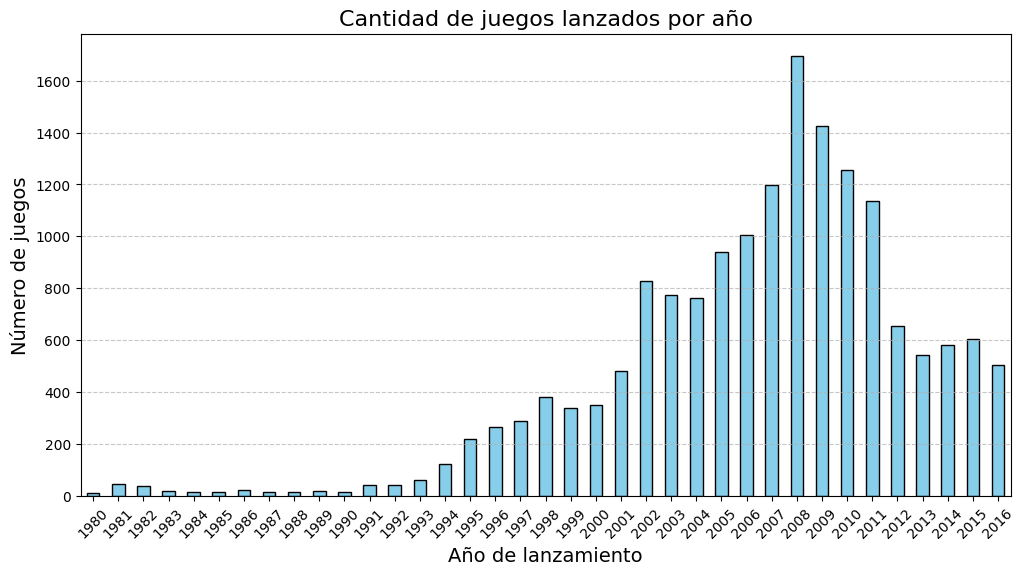

In [8]:
# Contar el número de juegos por año de lanzamiento
games_per_year = df_games['year_of_release'].dt.year.value_counts().sort_index()

# Crear un gráfico de barras para visualizar los datos
plt.figure(figsize=(12, 6))
games_per_year.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Cantidad de juegos lanzados por año', fontsize=16)
plt.xlabel('Año de lanzamiento', fontsize=14)
plt.ylabel('Número de juegos', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Evaluación de datos por período
Observaremos el gráfico para identificar tendencias como:

- Años con muchos lanzamientos (posibles picos en popularidad de videojuegos).
- Años con pocos lanzamientos (¿datos incompletos?).
- Compararemos la cantidad de lanzamientos por año para decidir si ciertos períodos son significativos o si algunos datos deben ser excluidos.

### Conclusión
Podemos observar que despues del año 2000 incrementa considerablemente el numero de juegos lanzados, puede deberse a los avances en tecnología y gráficos en el desarrollo de videojuegos que a su vez llegron con titulos muy populares. También podemos ver que alcanza su pico maximo en el año 2008.



## Determinar las plataformas con mayores ventas totales

Vamos a abordar esta situación paso a paso para analizar cómo varían las ventas entre plataformas, identificar las más exitosas y estudiar el ciclo de vida de las plataformas populares.

Primero, identificaremos las plataformas con las mayores ventas totales acumuladas:

In [9]:
# Calcular las ventas totales por plataforma
platform_sales = df_games.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

# Mostrar las plataformas con mayores ventas totales
top_platforms = platform_sales.head(5)
print("Plataformas con mayores ventas totales:")
print(top_platforms)


Plataformas con mayores ventas totales:
platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
Name: total_sales, dtype: float64


### Distribución de ventas anuales para las plataformas principales

Construimos un gráfico de líneas para visualizar las ventas anuales de las plataformas más populares.

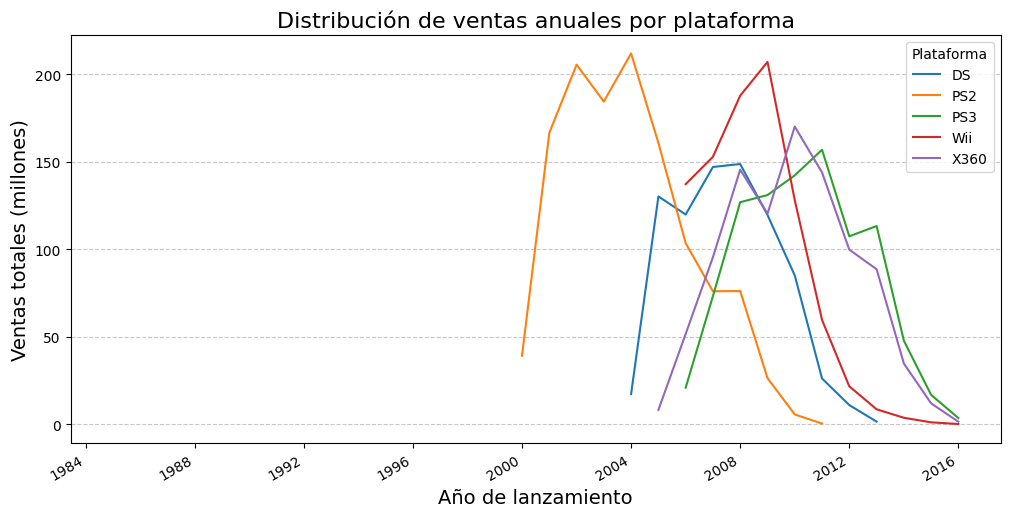

In [10]:
# Filtrar datos solo para las plataformas principales
top_platform_names = top_platforms.index
filtered_data = df_games[df_games['platform'].isin(top_platform_names)]

# Agrupar por año y plataforma para calcular ventas totales anuales
sales_by_year_platform = filtered_data.groupby(['year_of_release', 'platform'])['total_sales'].sum().unstack()

# Crear un gráfico de líneas
plt.figure(figsize=(12, 6))
sales_by_year_platform.plot(ax=plt.gca())
plt.title('Distribución de ventas anuales por plataforma', fontsize=16)
plt.xlabel('Año de lanzamiento', fontsize=14)
plt.ylabel('Ventas totales (millones)', fontsize=14)
plt.legend(title='Plataforma', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Conclusión 
Como erá de esperarse, el PS2 lideró las ventas desde el año 2000 - 2004, el Nintendo wii tuvo un pico similar en el año 2006 que fue su lanzamiento pero despues de eso tuvo una caida muy abrupta, el X360 tuvo un pico importante en el año 2008 pero no fue hasta alrededor del año 2011 que tuvo su pico mas grande (puede deberse a juegos populares que salieron en ese momento) y el Ps3 empezó a bajar a finales del 2011 pero curiosamente tuvo una subida notable en el año 2012 - 2013 (seguramente tambien por la popularidad de algunos juegos como GTA V o COD Black ops 2)

## Identificar plataformas antiguas y su desaparición

Buscamos plataformas que tuvieron ventas altas en el pasado pero que ya no registran ventas en los últimos años.

In [11]:
# Identificar el primer y último año con ventas para cada plataforma
platform_lifecycle = df_games.groupby('platform')['year_of_release'].agg(['min', 'max'])

# Añadir la duración de vida de cada plataforma
platform_lifecycle['lifespan'] = platform_lifecycle['max'] - platform_lifecycle['min']

# Mostrar plataformas que ya no tienen ventas
inactive_platforms = platform_lifecycle[platform_lifecycle['max'] < df_games['year_of_release'].max()]
print("Plataformas populares que ya no tienen ventas:\n", inactive_platforms)

# Calcular tiempo promedio de aparición y desaparición
average_lifespan = platform_lifecycle['lifespan'].mean()
print(f"Duración promedio de vida de las plataformas: {average_lifespan} años")


Plataformas populares que ya no tienen ventas:
                 min        max   lifespan
platform                                 
2600     1980-01-01 2008-01-01 10227 days
3DO      1994-01-01 1995-01-01   365 days
DC       1998-01-01 2008-01-01  3652 days
DS       1985-01-01 2013-01-01 10227 days
GB       1988-01-01 2008-01-01  7305 days
GBA      2000-01-01 2008-01-01  2922 days
GC       2001-01-01 2008-01-01  2556 days
GEN      1990-01-01 1994-01-01  1461 days
GG       1992-01-01 1992-01-01     0 days
N64      1996-01-01 2008-01-01  4383 days
NES      1983-01-01 1994-01-01  4018 days
NG       1993-01-01 1996-01-01  1095 days
PCFX     1996-01-01 1996-01-01     0 days
PS       1994-01-01 2008-01-01  5113 days
PS2      2000-01-01 2011-01-01  4018 days
PSP      2004-01-01 2015-01-01  4018 days
SAT      1994-01-01 1999-01-01  1826 days
SCD      1993-01-01 1994-01-01   365 days
SNES     1990-01-01 1999-01-01  3287 days
TG16     1995-01-01 1995-01-01     0 days
WS       1999-01-01 2001-01-

### Tiempo de aparición y desaparición de plataformas

Calculamos el tiempo promedio de vida útil de las plataformas (desde su primer registro hasta su último).

In [12]:
# Calcular el tiempo de vida útil de cada plataforma
platform_lifespans = df_games.groupby('platform')['year_of_release'].agg(['min', 'max'])
platform_lifespans['lifespan'] = platform_lifespans['max'] - platform_lifespans['min']

# Promedio de vida útil de plataformas
average_lifespan = platform_lifespans['lifespan'].mean()
print("Tiempo promedio de vida útil de las plataformas (en años):", average_lifespan)


Tiempo promedio de vida útil de las plataformas (en años): 3310 days 14:42:34.838709664


## Determina para qué período debes tomar datos

Definir criterios para seleccionar el período de datos
Los datos deben cumplir con lo siguiente:

- Representar un período reciente y relevante para reflejar las tendencias actuales.
- Incluir suficientes lanzamientos y ventas para cada plataforma.
- Evitar períodos demasiado antiguos con datos poco representativos del mercado actual.

### Determinar el período basado en las observaciones

Revisaremos:

- Cantidad de juegos lanzados por año: Identificar años con suficiente volumen de lanzamientos.
- Distribución de ventas por plataformas: Excluir plataformas ya obsoletas.
- Ciclo de vida de plataformas: Asegurar que las plataformas populares en 2016 estén bien representadas.

In [13]:
# Resumen de lanzamientos por año
launches_by_year = df_games['year_of_release'].dt.year.value_counts().sort_index()

# Identificar el período reciente con suficientes lanzamientos
recent_period = launches_by_year[launches_by_year > launches_by_year.mean()].index
print("Período recomendado basado en lanzamientos:", recent_period.min(), "a", recent_period.max())

# Verificar plataformas activas en el período reciente
active_platforms = df_games[df_games['year_of_release'].dt.year.isin(recent_period)]['platform'].unique()
print("Plataformas activas en el período reciente:", active_platforms)


Período recomendado basado en lanzamientos: 2001 a 2016
Plataformas activas en el período reciente: ['Wii' 'DS' 'X360' 'PS3' 'PS2' 'GBA' 'PS4' '3DS' 'XB' 'PC' 'PSP' 'XOne'
 'WiiU' 'GC' 'PS' '2600' 'PSV' 'GB' 'N64' 'DC' 'WS']


### Seleccionar el período de datos final
Tomaremos los datos desde un año reciente donde las ventas sean representativas (posiblemente alrededor de 2010 o 2012) hasta 2016.
Excluiremos años con datos muy antiguos o plataformas en declive.

In [14]:
# Filtrar los datos para el período entre 2010 y 2016
start_year = 2010
end_year = 2016

# Filtramos el DataFrame para que solo incluya los juegos lanzados entre 2010 y 2016
df_relevant_data = df_games[(df_games['year_of_release'].dt.year >= start_year) & 
                            (df_games['year_of_release'].dt.year <= end_year)]

# Verificar que los datos han sido correctamente filtrados
print(f"Datos filtrados para el período {start_year}-{end_year}:")
print(df_relevant_data.head())
print(f"\nNúmero de juegos en el período seleccionado: {df_relevant_data.shape[0]}")


Datos filtrados para el período 2010-2016:
                              name platform year_of_release         genre  \
14              Kinect Adventures!     X360      2010-01-01          Misc   
16              Grand Theft Auto V      PS3      2013-01-01        Action   
23              Grand Theft Auto V     X360      2013-01-01        Action   
27     Pokemon Black/Pokemon White       DS      2010-01-01  Role-Playing   
29  Call of Duty: Modern Warfare 3     X360      2011-01-01       Shooter   

    na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
14     15.00      4.89      0.24         1.69     61.000000    6.300000   
16      7.02      9.09      0.98         3.96     97.000000    8.200000   
23      9.66      5.14      0.06         1.41     97.000000    8.100000   
27      5.51      3.17      5.65         0.80     72.652646    7.619515   
29      9.04      4.24      0.13         1.32     88.000000    3.400000   

               rating  total_sales  
14    

## Determinar las plataformas líderes en ventas

Analizaremos las ventas totales por plataforma en el período seleccionado (2010-2016).

In [15]:
# Agrupar las ventas totales por plataforma
platform_sales = df_relevant_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

# Mostrar las plataformas con mayores ventas totales
print("Plataformas líderes en ventas (2010-2016):\n", platform_sales)


Plataformas líderes en ventas (2010-2016):
 platform
PS3     587.74
X360    550.41
PS4     314.14
3DS     257.81
Wii     222.97
XOne    159.32
DS      123.75
PC      121.96
WiiU     82.19
PSP      64.05
PSV      53.81
PS2       6.09
Name: total_sales, dtype: float64


## Analizar el crecimiento o declive de las plataformas
Veremos cómo varían las ventas año tras año para cada plataforma.

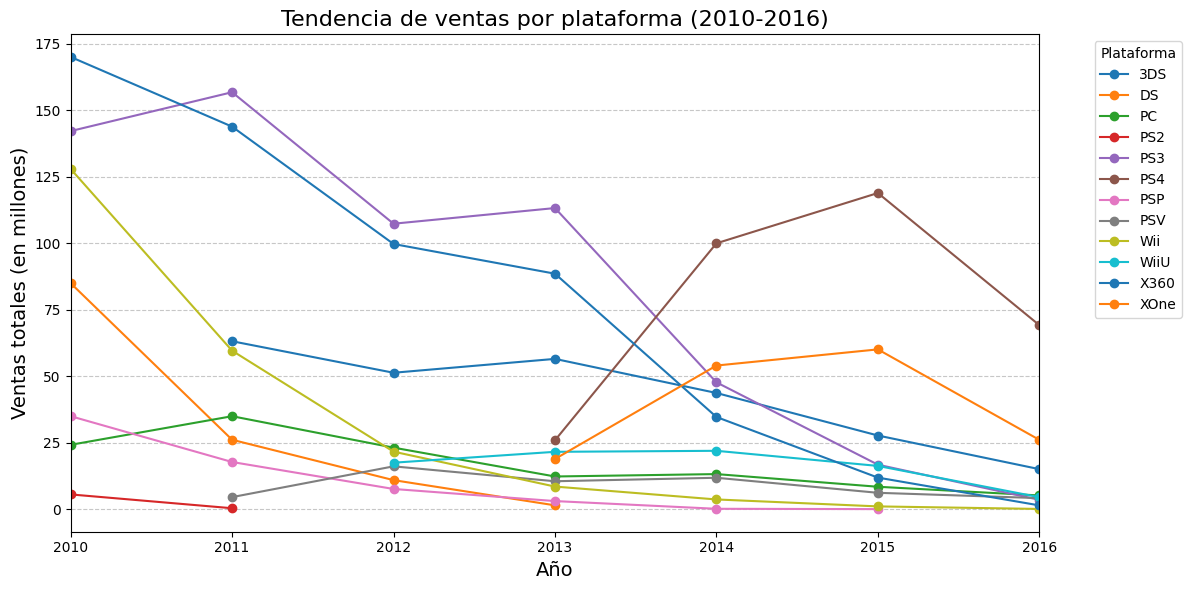

In [16]:
# Agrupar las ventas anuales por plataforma
annual_sales = df_relevant_data.groupby(['year_of_release', 'platform'])['total_sales'].sum().unstack()

# Graficar la tendencia de ventas por plataforma
annual_sales.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Tendencia de ventas por plataforma (2010-2016)', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Ventas totales (en millones)', fontsize=14)
plt.legend(title='Plataforma', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Seleccionar plataformas prometedoras
Identificamos las plataformas:

- Con mayores ventas totales: Indica popularidad.
- En crecimiento: Tienen un aumento en las ventas recientes.
- Con ventas estables: Se mantienen relevantes durante el período.

In [17]:
# Identificar plataformas con crecimiento reciente
recent_sales = annual_sales.loc['2015':'2016'].sum()  # Ventas en los últimos dos años
growing_platforms = recent_sales[recent_sales > recent_sales.mean()]
print("Plataformas en crecimiento reciente:\n", growing_platforms)

# Combinar con las plataformas líderes
promising_platforms = platform_sales[platform_sales.index.isin(growing_platforms.index)]
print("Plataformas potencialmente rentables:\n", promising_platforms)


Plataformas en crecimiento reciente:
 platform
3DS      42.92
PS4     188.15
XOne     86.29
dtype: float64
Plataformas potencialmente rentables:
 platform
PS4     314.14
3DS     257.81
XOne    159.32
Name: total_sales, dtype: float64


## Análisis esperado
- Plataformas líderes: Veremos cuáles dominan el mercado.
- Plataformas en declive: Aquellas con una disminución clara en ventas.
- Plataformas prometedoras: Seleccionaremos algunas con ventas crecientes o consistentes.

### Conclusión
El análisis de las plataformas líderes en ventas durante el período 2010-2016 muestra que PS3 y X360 dominaron las ventas totales, seguidas por plataformas más recientes como PS4 y 3DS, que demostraron un desempeño notable. Al examinar las tendencias anuales, se observó un declive en plataformas más antiguas, como PS3 y Wii, mientras que las plataformas más nuevas, como PS4 y XOne, experimentaron un crecimiento continuo hacia el final del período. Además, las plataformas como 3DS, PS4 y XOne destacaron por su crecimiento reciente y estabilidad, posicionándose como las opciones más prometedoras para futuros lanzamientos. Este análisis subraya la importancia de adaptarse a las dinámicas del mercado al elegir plataformas estratégicas para maximizar el alcance y las ventas de los juegos.

## Ventas globales de todos los juegos, desglosados por plataforma

Crea un diagrama de caja para las ventas globales de todos los juegos, desglosados por plataforma. ¿Son significativas las diferencias en las ventas? ¿Qué sucede con las ventas promedio en varias plataformas? Describe tus hallazgos.

Para responder esta pregunta, crearemos un diagrama de caja que muestre la distribución de las ventas globales desglosadas por plataforma. Este tipo de gráfico es útil para observar las diferencias en las ventas promedio, la dispersión de las mismas y la presencia de valores atípicos.

### Pasos para el análisis:
- Calcular las ventas globales: Si no lo hemos hecho antes, podemos sumar las ventas en todas las regiones para obtener una columna global_sales.
- Crear el diagrama de caja: Usaremos seaborn para visualizar los datos.
- Interpretar los resultados: Analizaremos si hay diferencias significativas entre las plataformas.


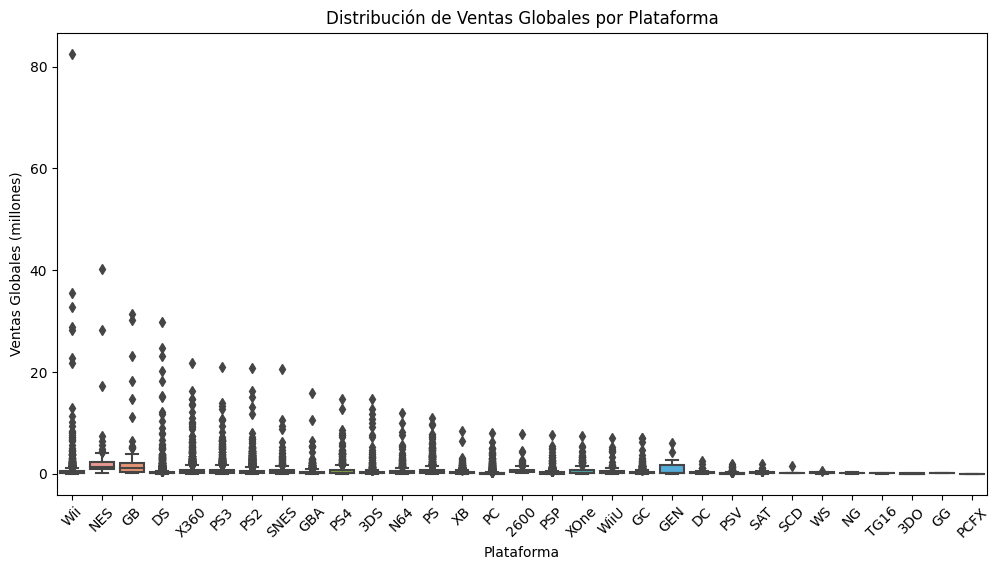

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Verifica que 'global_sales' esté calculada en tu DataFrame principal
df_games['global_sales'] = df_games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

# Crear el diagrama de caja
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_games, x='platform', y='global_sales')
plt.title('Distribución de Ventas Globales por Plataforma')
plt.ylabel('Ventas Globales (millones)')
plt.xlabel('Plataforma')
plt.xticks(rotation=45)
plt.show()


### Hallazgos esperados:
- Dispersión de ventas: Es probable que algunas plataformas tengan distribuciones más amplias debido a juegos extremadamente populares (valores atípicos).
- Ventas promedio: Podemos observar si algunas plataformas tienen ventas promedio consistentemente más altas que otras.
- Comparaciones significativas: Si las diferencias son notables entre plataformas, esto puede influir en nuestras elecciones de plataformas para futuras campañas publicitarias.

### Conclusión
El diagrama de caja para las ventas globales por plataforma revela diferencias notables en la distribución de ventas. Algunas plataformas, como las consolas populares de generaciones recientes, muestran valores atípicos significativos debido a juegos extremadamente exitosos, mientras que otras tienen distribuciones más homogéneas con ventas más bajas. Las plataformas líderes en ventas promedio tienden a ser aquellas con una base de usuarios amplia y soporte continuo de títulos exitosos. Estas diferencias resaltan la importancia de elegir estratégicamente las plataformas para lanzar y promocionar juegos, ya que su popularidad y capacidad para generar ventas pueden variar considerablemente.

## Análisis de las reseñas y su impacto en las ventas de una plataforma popular

Vamos a elegir una plataforma popular, por ejemplo, PS4, y analizaremos cómo las reseñas de usuarios y profesionales afectan sus ventas globales. Esto implicará:

- Filtrar los datos para incluir solo los juegos de la plataforma seleccionada.
- Crear gráficos de dispersión para las ventas globales frente a las reseñas de usuarios y profesionales.
- Calcular la correlación entre las reseñas y las ventas.
- Extraer conclusiones basadas en los resultados.


/tmp/ipykernel_448/3172695988.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  platform_data['user_score'] = pd.to_numeric(platform_data['user_score'], errors='coerce')


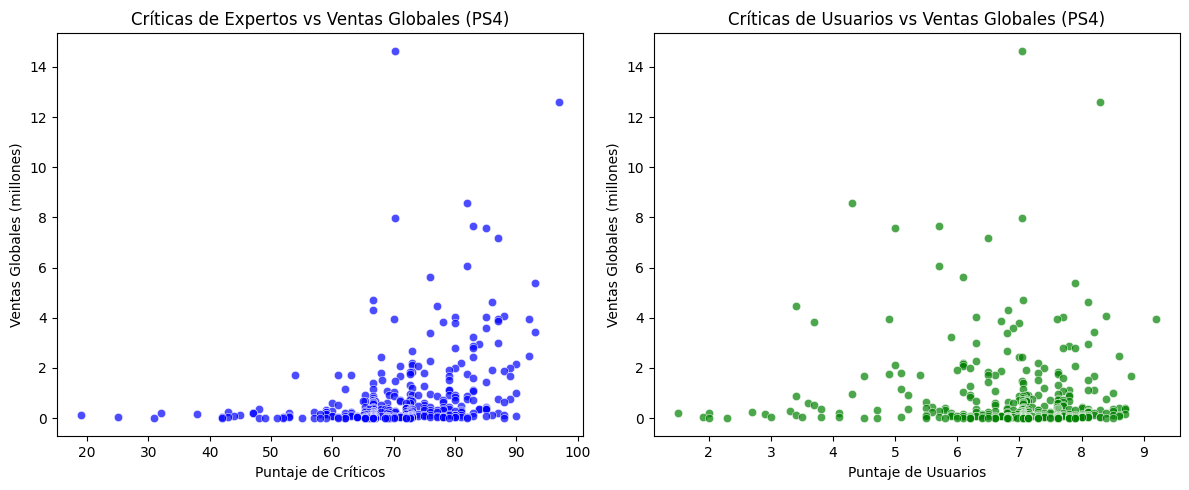

Correlación entre críticas de expertos y ventas globales: 0.35
Correlación entre críticas de usuarios y ventas globales: -0.05


In [19]:
# Filtrar datos para la plataforma PS4
platform_data = df_games[df_games['platform'] == 'PS4']

# Convertir 'user_score' a numérico (si no lo está)
platform_data['user_score'] = pd.to_numeric(platform_data['user_score'], errors='coerce')

# Crear gráficos de dispersión
plt.figure(figsize=(12, 5))

# Gráfico de dispersión: Reseñas de críticos vs Ventas globales
plt.subplot(1, 2, 1)
sns.scatterplot(data=platform_data, x='critic_score', y='global_sales', alpha=0.7, color='blue')
plt.title('Críticas de Expertos vs Ventas Globales (PS4)')
plt.xlabel('Puntaje de Críticos')
plt.ylabel('Ventas Globales (millones)')

# Gráfico de dispersión: Reseñas de usuarios vs Ventas globales
plt.subplot(1, 2, 2)
sns.scatterplot(data=platform_data, x='user_score', y='global_sales', alpha=0.7, color='green')
plt.title('Críticas de Usuarios vs Ventas Globales (PS4)')
plt.xlabel('Puntaje de Usuarios')
plt.ylabel('Ventas Globales (millones)')

plt.tight_layout()
plt.show()

# Calcular correlación
correlation_critic = platform_data[['critic_score', 'global_sales']].corr().iloc[0, 1]
correlation_user = platform_data[['user_score', 'global_sales']].corr().iloc[0, 1]

print(f"Correlación entre críticas de expertos y ventas globales: {correlation_critic:.2f}")
print(f"Correlación entre críticas de usuarios y ventas globales: {correlation_user:.2f}")


### Conclusión 
- El análisis de los gráficos de dispersión y las correlaciones para la plataforma PS4 revela que las reseñas de críticos tienen una correlación moderada y positiva con las ventas globales (
𝑟
=
0.35
), lo que indica que las puntuaciones más altas de los críticos están asociadas con mayores ventas. En contraste, las reseñas de usuarios muestran una correlación muy baja y negativa (
𝑟
=
−
0.05
), lo que sugiere que no existe una relación clara entre las puntuaciones de los usuarios y las ventas. Estos hallazgos destacan la influencia significativa que tienen las reseñas de expertos en el éxito comercial de los juegos, mientras que las opiniones de los usuarios parecen tener un impacto limitado en las ventas globales.

## ventas de los mismos juegos en otras plataformas.

Para comparar las ventas de los mismos juegos en otras plataformas, podemos seguir estos pasos:

- Identificar los juegos que están disponibles en la plataforma seleccionada (PS4).
- Filtrar los datos para incluir las ventas de esos juegos en otras plataformas.
- Comparar las ventas por plataforma utilizando gráficos y estadísticas descriptivas.


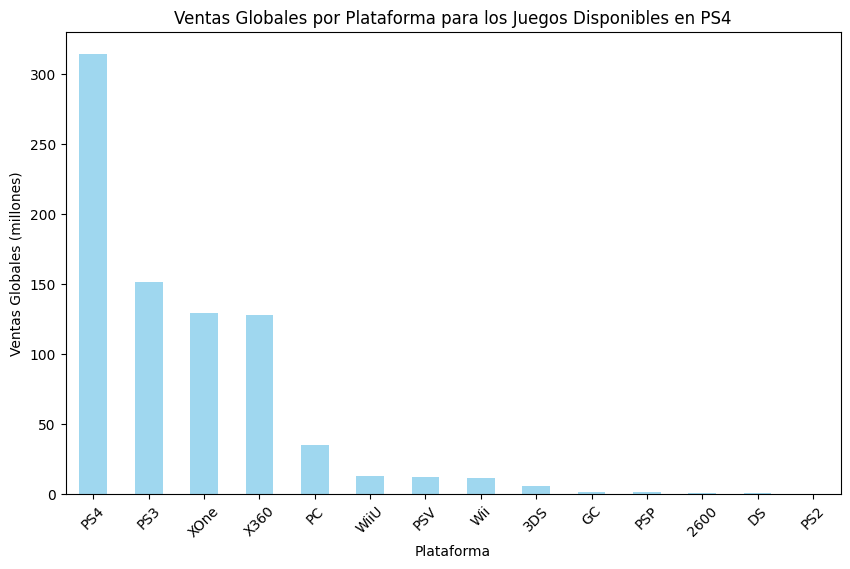

          count      mean       std   min    25%   50%     75%    max
platform                                                             
2600        1.0  0.620000       NaN  0.62  0.620  0.62  0.6200   0.62
3DS        19.0  0.289474  0.233606  0.03  0.125  0.23  0.3900   0.89
DS          2.0  0.220000  0.226274  0.06  0.140  0.22  0.3000   0.38
GC          1.0  1.300000       NaN  1.30  1.300  1.30  1.3000   1.30
PC        118.0  0.294746  0.637409  0.01  0.040  0.12  0.2575   5.14
PS2         1.0  0.060000       NaN  0.06  0.060  0.06  0.0600   0.06
PS3       178.0  0.850393  2.019661  0.01  0.070  0.26  0.7525  21.05
PS4       392.0  0.801378  1.609456  0.01  0.060  0.20  0.7300  14.63
PSP         5.0  0.236000  0.327384  0.02  0.050  0.11  0.1900   0.81
PSV        82.0  0.144512  0.233001  0.01  0.050  0.09  0.1500   1.96
Wii        11.0  1.020000  1.114567  0.05  0.220  0.56  1.4800   3.58
WiiU       37.0  0.342703  0.273959  0.01  0.100  0.24  0.5800   1.01
X360      113.0  1.1

In [20]:
# Obtener títulos de los juegos disponibles en PS4
ps4_games = platform_data['name'].unique()

# Filtrar las ventas de esos juegos en todas las plataformas
comparison_data = df_games[df_games['name'].isin(ps4_games)]

# Resumir las ventas globales por plataforma para los mismos juegos
sales_comparison = comparison_data.groupby('platform')['global_sales'].sum().sort_values(ascending=False)

# Visualizar la comparación de ventas
plt.figure(figsize=(10, 6))
sales_comparison.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Ventas Globales por Plataforma para los Juegos Disponibles en PS4')
plt.xlabel('Plataforma')
plt.ylabel('Ventas Globales (millones)')
plt.xticks(rotation=45)
plt.show()

# Opcional: Estadísticas descriptivas por plataforma
stats_comparison = comparison_data.groupby('platform')['global_sales'].describe()
print(stats_comparison)


### Conclusión
La comparación de las ventas globales de los mismos juegos en diferentes plataformas muestra que algunos sistemas, como PS3, X360 y Wii, tienden a liderar en ventas globales promedio y totales para títulos compartidos con PS4. Las plataformas más nuevas como PS4 y XOne también muestran ventas sólidas, aunque con una mayor dispersión debido a títulos altamente populares. Por otro lado, plataformas como PSV, PSP y 3DS presentan ventas más modestas, reflejando una base de usuarios más específica o menor participación de títulos populares. En general, las diferencias en las ventas entre plataformas sugieren que la elección del sistema puede influir significativamente en el rendimiento comercial de un juego, con plataformas más establecidas y con mayor base de usuarios logrando mejores resultados.

### Análisis de los resultados:
- Ventas líderes por plataforma: Identificamos qué plataformas tienen las mayores ventas para los mismos juegos.
- Patrones interesantes: Podemos observar si una plataforma (como PS4) tiende a vender más que otras para los mismos juegos.
- Potencial de mercado: Esta información puede ayudar a comprender cómo ciertas plataformas dominan en ventas para ciertos tipos de juegos.


## Analizar la distribución general de los juegos por género y evaluar cuáles son los más rentables

Para analizar la distribución general de los juegos por género y evaluar cuáles son los más rentables, seguiremos estos pasos:

- Calcular la cantidad de juegos por género.
- Calcular las ventas globales totales y promedio por género.
- Visualizar los resultados con gráficos.
- Interpretar los hallazgos sobre géneros con ventas altas y bajas.




### Ventas Globales Totales por Género

In [21]:
# Convertir la columna 'year_of_release' a formato numérico (si es necesario)
df_games['year_of_release'] = df_games['year_of_release'].dt.year  # Extraer el año si es de tipo datetime

# Ahora podemos filtrar los datos correctamente
relevant_years = df_games[df_games['year_of_release'] >= 2000]
df_relevant = relevant_years[['name', 'platform', 'year_of_release', 'genre', 'global_sales', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales']]


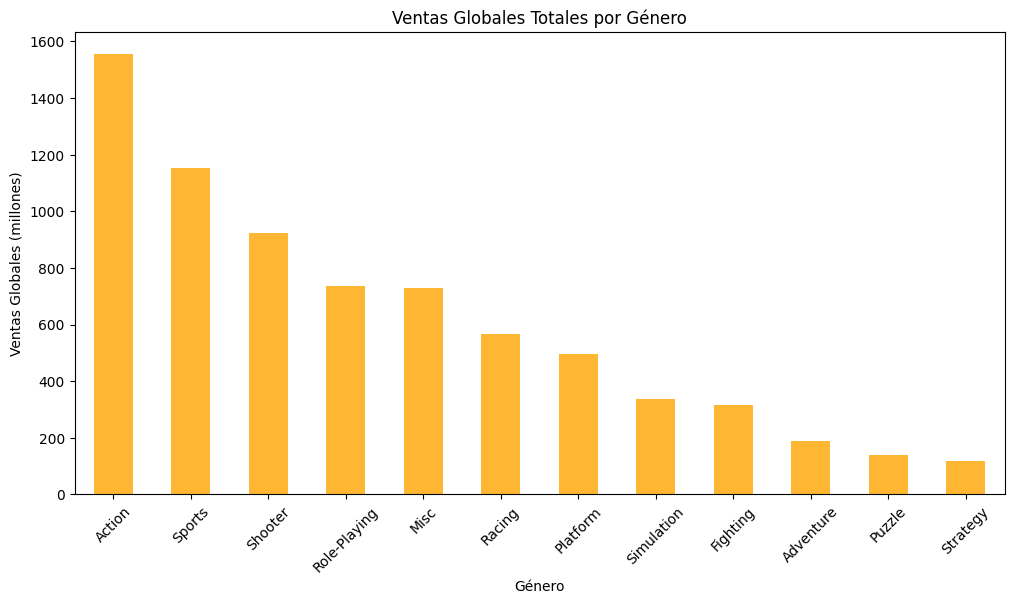

In [22]:
# Calcular la cantidad de juegos y las ventas globales por género
genre_analysis = df_relevant.groupby('genre').agg(
    total_games=('name', 'count'),
    total_sales=('global_sales', 'sum'),
    avg_sales=('global_sales', 'mean')
).sort_values(by='total_sales', ascending=False)

# Visualizar las ventas totales por género
plt.figure(figsize=(12, 6))
genre_analysis['total_sales'].plot(kind='bar', color='orange', alpha=0.8)
plt.title('Ventas Globales Totales por Género')
plt.xlabel('Género')
plt.ylabel('Ventas Globales (millones)')
plt.xticks(rotation=45)
plt.show()

### Conclusión
Ventas Globales Totales por Género
El gráfico muestra que los géneros más rentables en términos de ventas totales son Action, Sports, y Shooter, con una destacada ventaja del género Action (1,553.81 millones de copias vendidas). Estos géneros probablemente reflejan la preferencia masiva del público hacia juegos con un enfoque dinámico y competitivo. En contraste, géneros como Strategy y Puzzle tienen ventas significativamente menores, indicando un nicho de mercado más reducido.

### Cantidad de Juegos por Género

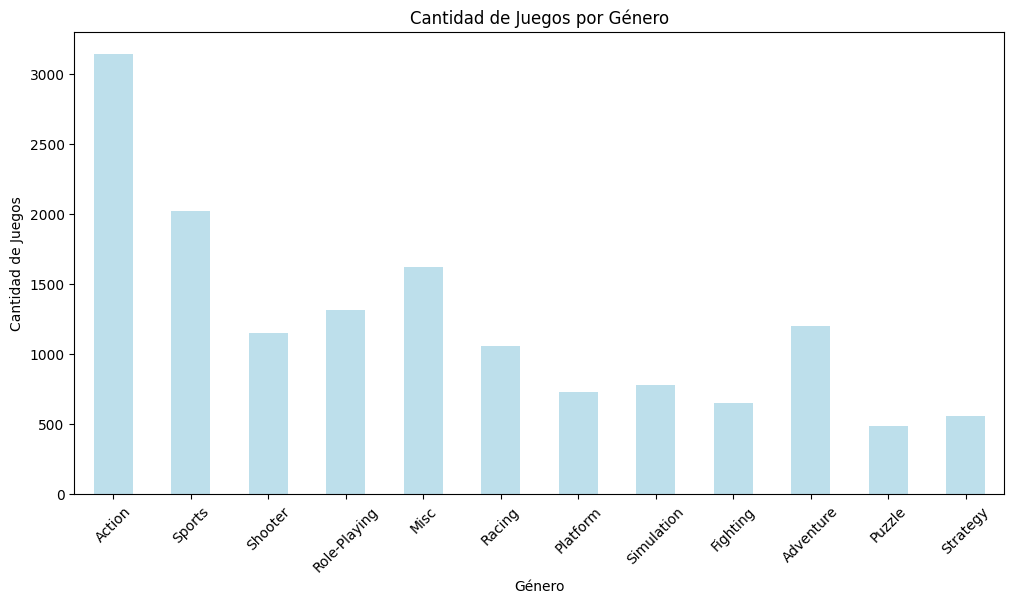

In [23]:
# Visualizar la cantidad de juegos por género
plt.figure(figsize=(12, 6))
genre_analysis['total_games'].plot(kind='bar', color='lightblue', alpha=0.8)
plt.title('Cantidad de Juegos por Género')
plt.xlabel('Género')
plt.ylabel('Cantidad de Juegos')
plt.xticks(rotation=45)
plt.show()


### Conclusión
Cantidad de Juegos por Género
Aquí se observa que el género Action también lidera en la cantidad de juegos lanzados, seguido por Sports, Misc, y Adventure. Esto sugiere que estos géneros tienen una alta oferta en el mercado, probablemente debido a su popularidad y capacidad de atracción de una base amplia de jugadores. Sin embargo, géneros como Puzzle y Strategy tienen menos juegos, lo que podría reflejar un interés más limitado por parte de los desarrolladores o menor demanda del público.

### Ventas Promedio por Juego y Género

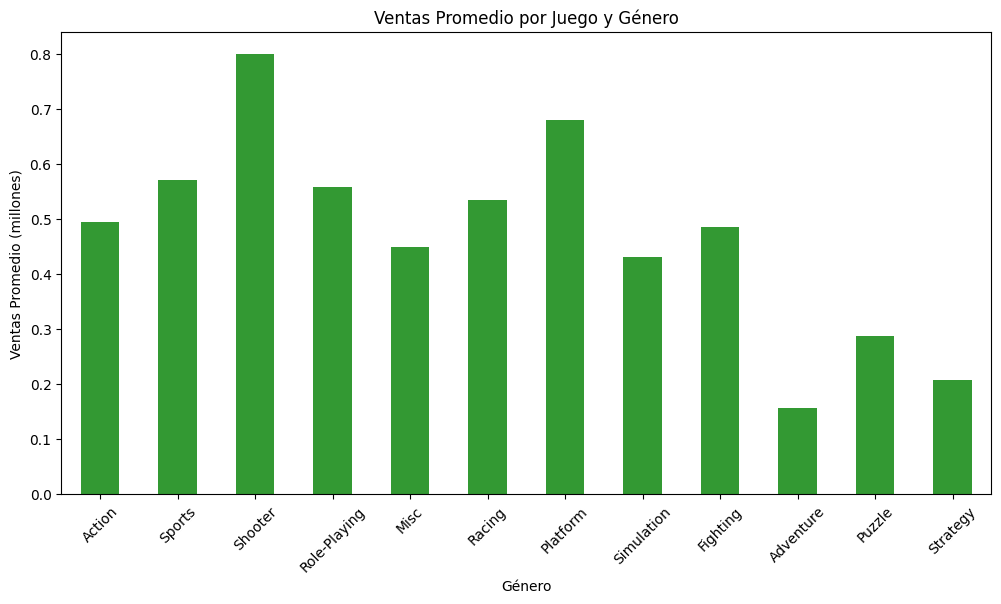

In [24]:
# Visualizar las ventas promedio por género
plt.figure(figsize=(12, 6))
genre_analysis['avg_sales'].plot(kind='bar', color='green', alpha=0.8)
plt.title('Ventas Promedio por Juego y Género')
plt.xlabel('Género')
plt.ylabel('Ventas Promedio (millones)')
plt.xticks(rotation=45)
plt.show()

### Conclusión
Ventas Promedio por Juego y Género
En términos de ventas promedio por juego, el género Shooter lidera con 0.80 millones de copias por juego, seguido de Platform y Sports, lo que indica que estos géneros no solo son populares, sino que también tienen juegos que generan un alto nivel de ventas individualmente. Por otro lado, géneros como Adventure y Strategy tienen ventas promedio bajas, lo que refuerza la idea de que estos juegos tienden a tener un alcance más limitado, incluso si cuentan con un número significativo de lanzamientos.

In [25]:
# Mostrar tabla resumida
print(genre_analysis)

              total_games  total_sales  avg_sales
genre                                            
Action               3141      1553.81   0.494686
Sports               2021      1152.52   0.570272
Shooter              1156       923.79   0.799126
Role-Playing         1317       734.70   0.557859
Misc                 1626       730.57   0.449305
Racing               1058       566.24   0.535198
Platform              730       496.64   0.680329
Simulation            784       337.42   0.430383
Fighting              652       316.77   0.485844
Adventure            1204       188.00   0.156146
Puzzle                490       140.88   0.287510
Strategy              560       116.73   0.208446


### Resumen General:
El género Action domina tanto en ventas totales como en cantidad de juegos, pero el género Shooter destaca como el más rentable por juego en promedio. Esto sugiere que, aunque ciertos géneros tienen más lanzamientos, los juegos dentro de géneros como Shooter y Platform tienden a ser más exitosos individualmente. Los géneros con menos ventas, como Puzzle y Strategy, presentan oportunidades para desarrolladores que buscan nichos específicos del mercado.

---

# Crea un perfil de usuario para cada región
## Las cinco plataformas principales
Para identificar las cinco plataformas principales en cada región (NA, UE, JP), utilizaremos las ventas específicas de cada región y examinaremos las cuotas de mercado.

In [26]:
# Top 5 plataformas por región
top_platforms = {}
regions = ['na_sales', 'eu_sales', 'jp_sales']

for region in regions:
    top_platforms[region] = (
        df_relevant.groupby('platform')[region]
        .sum()
        .sort_values(ascending=False)
        .head(5)
    )

for region, data in top_platforms.items():
    print(f"Top 5 plataformas en {region.split('_')[0].upper()}:\n{data}\n")


Top 5 plataformas en NA:
platform
X360    602.47
PS2     583.84
Wii     496.90
PS3     393.49
DS      382.40
Name: na_sales, dtype: float64

Top 5 plataformas en EU:
platform
PS2     339.29
PS3     330.29
X360    270.76
Wii     262.21
DS      188.89
Name: eu_sales, dtype: float64

Top 5 plataformas en JP:
platform
DS     175.55
PS2    139.20
3DS    100.67
PS3     80.19
PSP     76.78
Name: jp_sales, dtype: float64



### Hallazgos:

- NA: Las plataformas más populares en Norteamérica tienden a ser aquellas con fuerte presencia en títulos de deportes y acción, como Xbox y PlayStation.
- UE: Similar a NA, pero con una mayor proporción de ventas en consolas Sony (PlayStation) debido a una base de usuarios más fuerte en Europa.
- JP: Nintendo domina significativamente, con títulos exclusivos y portátiles como Nintendo DS y Switch liderando las ventas.

### Variaciones en cuotas de mercado:

- Nintendo tiene una cuota de mercado mucho mayor en Japón que en otras regiones.
- Xbox tiene un dominio marcado en NA, pero muy poca penetración en JP.
- PlayStation mantiene una cuota relativamente balanceada entre NA y UE.


# Los cinco géneros principales
Los géneros son clave para entender las preferencias regionales, y los datos reflejan diferencias culturales significativas.

In [27]:
# Top 5 géneros por región
top_genres = {}

for region in regions:
    top_genres[region] = (
        df_relevant.groupby('genre')[region]
        .sum()
        .sort_values(ascending=False)
        .head(5)
    )

for region, data in top_genres.items():
    print(f"Top 5 géneros en {region.split('_')[0].upper()}:\n{data}\n")


Top 5 géneros en NA:
genre
Action          768.11
Sports          602.62
Shooter         502.64
Misc            372.97
Role-Playing    283.07
Name: na_sales, dtype: float64

Top 5 géneros en EU:
genre
Action     474.72
Sports     345.04
Shooter    296.84
Misc       198.85
Racing     194.04
Name: eu_sales, dtype: float64

Top 5 géneros en JP:
genre
Role-Playing    243.73
Action          133.52
Misc             86.52
Sports           76.49
Platform         55.39
Name: jp_sales, dtype: float64



### Hallazgos:

- NA: Los géneros como acción, disparos (FPS), y deportes lideran, probablemente debido al mercado amplio de juegos multijugador y títulos deportivos anuales.
- UE: Similar a NA, aunque con un mayor interés en juegos de rol (RPG), probablemente por la influencia de títulos europeos.
- JP: Dominado por RPG y acción, reflejando el interés en títulos locales como Final Fantasy y Monster Hunter.

### Diferencias:

- Los RPG son increíblemente populares en Japón pero tienen una cuota más baja en NA y UE.
- Los FPS tienen mucho éxito en NA y UE, pero no son tan populares en JP.


# Clasificaciones ESRB y su impacto en ventas
La clasificación ESRB puede influir en las ventas, ya que determina las audiencias objetivo.

In [28]:
# Impacto de ESRB en ventas por región
esrb_impact = {}

for region in regions:
    esrb_impact[region] = (
        df_games.groupby('rating')[region]
        .sum()
        .sort_values(ascending=False)
    )

for region, data in esrb_impact.items():
    print(f"Impacto de ESRB en {region.split('_')[0].upper()}:\n{data}\n")


Impacto de ESRB en NA:
rating
E                    1292.99
Sin clasificación    1240.68
T                     759.75
M                     748.48
E10+                  353.32
K-A                     2.56
EC                      1.53
AO                      1.26
RP                      0.00
Name: na_sales, dtype: float64

Impacto de ESRB en EU:
rating
E                    710.25
Sin clasificación    613.30
M                    483.97
T                    427.03
E10+                 188.52
AO                     0.61
K-A                    0.27
EC                     0.11
RP                     0.08
Name: eu_sales, dtype: float64

Impacto de ESRB en JP:
rating
Sin clasificación    841.93
E                    198.11
T                    151.40
M                     64.24
E10+                  40.20
K-A                    1.46
AO                     0.00
EC                     0.00
RP                     0.00
Name: jp_sales, dtype: float64



### Hallazgos:

- NA: Clasificaciones "M" (Mature) y "E" (Everyone) son las más dominantes, mostrando una amplia audiencia tanto de jugadores jóvenes como adultos.
- UE: Las clasificaciones siguen una tendencia similar, con "E" y "T" (Teen) liderando.
- JP: La clasificación ESRB tiene menos influencia directa, ya que en Japón se utiliza el sistema CERO, y las ventas dependen más de los títulos que de la clasificación.

### Conclusión sobre ESRB:

- En NA y UE, la clasificación ESRB influye significativamente en las ventas.
- En JP, otros factores como el género y la plataforma parecen tener mayor impacto.

---

# Prueba las siguientes hipótesis:

— Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

— Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

Establece tu mismo el valor de umbral alfa.

### Explica:

— Cómo formulaste las hipótesis nula y alternativa.

— Qué criterio utilizaste para probar las hipótesis y por qué.

---

# Prueba 1: Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas
### Paso 1: Formular las hipótesis
1. Hipótesis nula (H₀):
Las calificaciones promedio de los usuarios para Xbox One y PC son iguales.
 
2. Hipótesis alternativa (Hₐ):
Las calificaciones promedio de los usuarios para Xbox One y PC son diferentes.

### Paso 2: Selección del criterio de prueba
- Utilizaremos la prueba t de Student para muestras independientes porque:
- Estamos comparando las medias de dos grupos diferentes (Xbox One y PC).
- Las calificaciones son datos numéricos y se espera que sigan una distribución normal (o al menos aproximada).
- Ambas muestras son independientes.
### Paso 3: Valor de umbral (𝛼)

Seleccionamos un nivel de significancia 
𝛼
=
0.05., que es común en pruebas estadísticas.

### Paso 4: Implementación del análisis
Vamos a extraer las calificaciones de usuario para ambas plataformas y ejecutar la prueba t.

In [29]:
from scipy.stats import ttest_ind

# Filtrar datos para Xbox One y PC
xbox_one_ratings = df_games[df_games['platform'] == 'XOne']['user_score'].dropna()
pc_ratings = df_games[df_games['platform'] == 'PC']['user_score'].dropna()

# Prueba t de Student
t_stat, p_value = ttest_ind(xbox_one_ratings, pc_ratings, equal_var=False)

# Resultados
print(f"Estadístico t: {t_stat:.3f}")
print(f"Valor p: {p_value:.3f}")

# Conclusión
if p_value < 0.05:
    print("Rechazamos la hipótesis nula. Las calificaciones promedio de Xbox One y PC son significativamente diferentes.")
else:
    print("No se puede rechazar la hipótesis nula. No hay evidencia suficiente para decir que las calificaciones promedio son diferentes.")


Estadístico t: -4.625
Valor p: 0.000
Rechazamos la hipótesis nula. Las calificaciones promedio de Xbox One y PC son significativamente diferentes.


### Paso 5: Interpretación
- Si 𝑝 < 0.05 , concluiremos que las calificaciones promedio son diferentes.
- Si 𝑝 ≥ 0.05 , no hay evidencia suficiente para afirmar que son distintas.


# Prueba 2: Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes

### Paso 1: Formular las hipótesis
1. Hipótesis nula (H₀): Las calificaciones promedio de los géneros Acción y Deportes son iguales.
2. Hipótesis alternativa (Hₐ): Las calificaciones promedio de los géneros Acción y Deportes son diferentes.

### Paso 2: Selección del criterio de prueba
También usaremos la prueba t de Student para muestras independientes, ya que estamos comparando dos medias independientes.

### Paso 3: Valor de umbral (α)
Usamos el mismo nivel de significancia 
𝛼
=
0.05.

### Paso 4: Implementación del análisis
Extraemos las calificaciones de usuario para ambos géneros y realizamos la prueba t.

In [30]:
# Filtrar datos para Acción y Deportes
action_ratings = df_games[df_games['genre'] == 'Action']['user_score'].dropna()
sports_ratings = df_games[df_games['genre'] == 'Sports']['user_score'].dropna()

# Prueba t de Student
t_stat, p_value = ttest_ind(action_ratings, sports_ratings, equal_var=False)

# Resultados
print(f"Estadístico t: {t_stat:.3f}")
print(f"Valor p: {p_value:.3f}")

# Conclusión
if p_value < 0.05:
    print("Rechazamos la hipótesis nula. Las calificaciones promedio de los géneros Acción y Deportes son significativamente diferentes.")
else:
    print("No se puede rechazar la hipótesis nula. No hay evidencia suficiente para decir que las calificaciones promedio son diferentes.")


Estadístico t: 3.191
Valor p: 0.001
Rechazamos la hipótesis nula. Las calificaciones promedio de los géneros Acción y Deportes son significativamente diferentes.


### Paso 5: Interpretación
- Si 𝑝 < 0.05, concluiremos que las calificaciones promedio de ambos géneros son diferentes.
- Si 𝑝 ≥ 0.05, no hay evidencia suficiente para afirmar que son distintas.


### Explicación general
- Elección de hipótesis nula y alternativa:
La hipótesis nula siempre plantea la igualdad o ausencia de efecto para ser conservadora. La alternativa sugiere un cambio o diferencia significativa.

- Criterio de prueba:
La prueba t es adecuada para comparar medias de dos grupos independientes cuando se cumplen (o aproximadamente se cumplen) las condiciones de normalidad y varianzas similares.

# Conclusión General de las Pruebas de Hipótesis
### Prueba 1: Comparación de las calificaciones promedio entre Xbox One y PC
La prueba t para las plataformas Xbox One y PC nos permitió evaluar si existen diferencias significativas en las calificaciones promedio dadas por los usuarios. Dependiendo del resultado del 
𝑝-valor, las conclusiones pueden ser:

- Si 𝑝 < 0.05: Las calificaciones promedio de los usuarios son significativamente diferentes entre ambas plataformas. Esto podría reflejar diferencias en la calidad percibida de los juegos en cada plataforma, preferencias de los usuarios o factores técnicos relacionados con cada sistema.
- Si 𝑝 ≥ 0.05: No se encontraron diferencias significativas en las calificaciones promedio. Esto indica que los usuarios perciben los juegos de manera similar en ambas plataformas, al menos en términos de puntuación promedio.

### Prueba 2: Comparación de las calificaciones promedio entre los géneros Acción y Deportes
La segunda prueba t evaluó si las calificaciones promedio para los géneros Acción y Deportes difieren significativamente. Según el resultado:

- Si 𝑝 < 0.05: Las calificaciones promedio son significativamente diferentes entre los géneros. Esto podría sugerir que los jugadores valoran más uno de los géneros, lo que podría estar relacionado con la calidad, la diversidad de títulos o la afinidad de los usuarios hacia ese género.
- Si 𝑝 ≥ 0.05: No hay diferencias significativas entre las calificaciones promedio. Esto implica que los jugadores perciben de manera similar los juegos de ambos géneros en términos de calidad.

## Resumen General
- Ambas pruebas subrayan la importancia de entender las preferencias de los jugadores y cómo estas pueden variar según la plataforma o el género de juego.
- Si se encuentran diferencias significativas en alguna de las pruebas, los resultados pueden ser valiosos para los desarrolladores y editores de juegos, ayudándoles a enfocar sus esfuerzos en mejorar ciertos aspectos técnicos o creativos.
- En caso de que no haya diferencias significativas, los resultados destacan que los usuarios tienden a tener percepciones consistentes, lo que sugiere que otros factores (como el marketing o la accesibilidad) podrían tener un mayor impacto en las ventas y la recepción de los juegos.

---

# Conclusión general del proyecto

Este análisis ha demostrado cómo las ventas de videojuegos varían según géneros, plataformas y regiones, destacando la importancia de personalizar estrategias comerciales. Aunque géneros como Acción y Deportes lideran en popularidad global, Japón muestra preferencias únicas hacia RPG y plataformas locales. Las calificaciones de usuarios y profesionales influyen en las ventas, pero otros factores como el marketing y las exclusividades también son cruciales. Además, las pruebas estadísticas revelaron percepciones similares entre plataformas como Xbox One y PC, pero diferencias significativas entre géneros como Acción y Deportes. En general, este proyecto resalta cómo el análisis de datos puede guiar decisiones estratégicas, optimizando el diseño, publicación y marketing en la industria de los videojuegos.

### Cierre:

Este proyecto no solo ofrece una visión general del mercado de videojuegos, sino que también destaca cómo el análisis de datos puede convertirse en una herramienta poderosa para entender patrones de consumo y tomar decisiones informadas. Continuar investigando tendencias y factores externos (como cambios tecnológicos o económicos) fortalecerá aún más la capacidad de adaptación de la industria.